In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
casp = pd.read_csv("CASP.csv")
casp.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


It is often a good idea to start gathering all information about the data we are trying to use. We will try to extract three layers of information from this dataset. Just to make it easier for us to do this, it is a good idea to wrap these commands into a function **get_dataset_details**. 

Here is a function that prints all the relevant details about the data.

* df.info() provides details about the non-null entries in each column of the dataframe
* df.describe() lists down all the relevant statistical features about the dataset like count, mean, standard deviation
* df.hist(), with "bins" argument, plots how each of the features are distrbuted

In [4]:
def get_dataset_details(df):
    print(df.info(),'\n')
    print(df.describe(),'\n')
    plt.show();

In [5]:
get_dataset_details(casp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB
None 

               RMSD            F1            F2            F3            F4  \
count  45730.000000  45730.000000  45730.000000  45730.000000  45730.000000   
mean       7.748528   9871.596995   3017.367175      0.302392    103.492433   
std        6.118312   4058.138034   1464.324663      0.062886     55.424985   
min        0.000000   2392.050000    403.500000      0.092500     10.31010

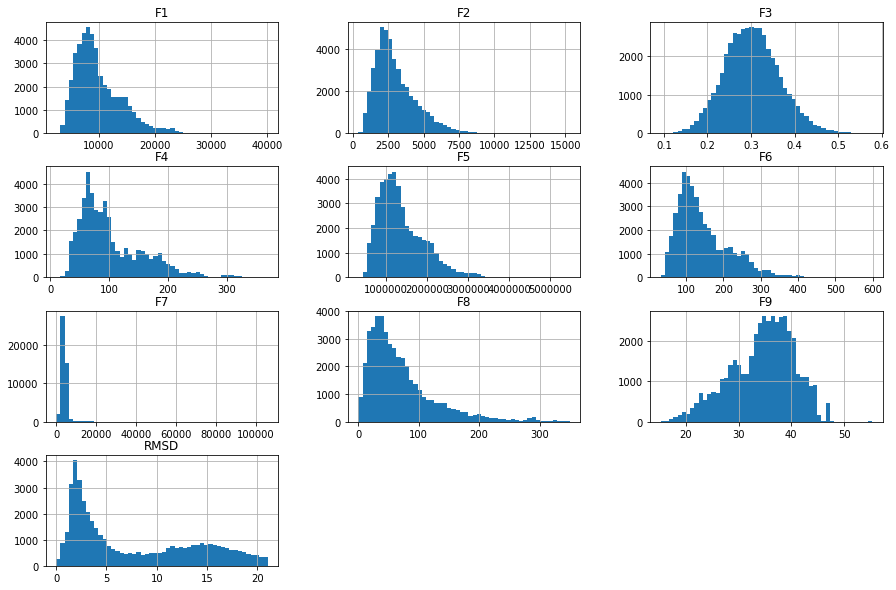

In [6]:
casp.hist(bins=50, figsize=(15,10));

Let us see if there is any missing data in the dataset

In [7]:
np.where(casp.values == np.nan)

(array([], dtype=int64), array([], dtype=int64))

In [8]:
def get_correlation(data):
    plt.figure(figsize=(15,10));
    pd.plotting.scatter_matrix(data, figsize=(20,10));

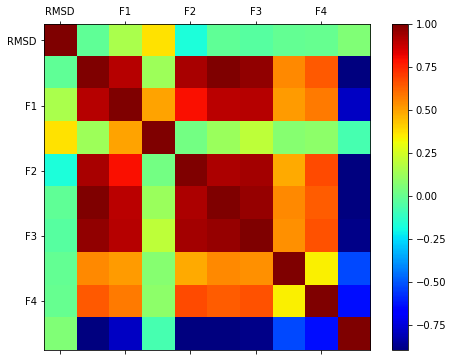

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(casp.corr(), cmap = 'jet', interpolation='none')
fig.colorbar(cax)

ax.set_xticklabels(['']+list(casp));
ax.set_yticklabels(['']+list(casp));

<Figure size 1080x720 with 0 Axes>

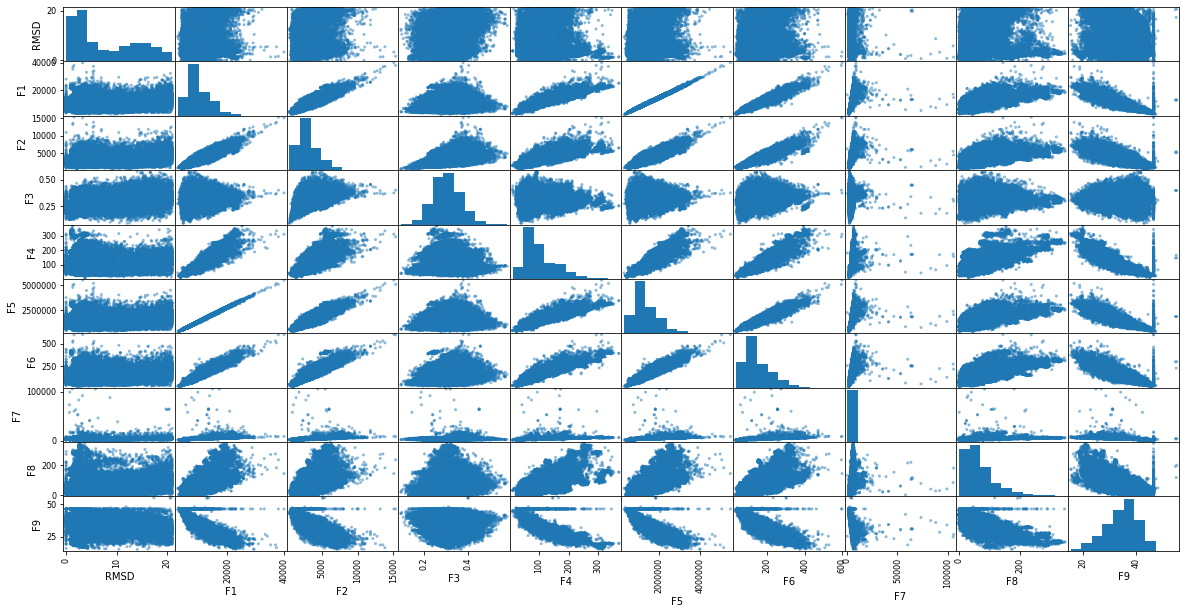

In [10]:
get_correlation(casp)

In [11]:
casp[casp['F7']<7500].corr()['RMSD'].sort_values(ascending=False)

RMSD    1.000000
F3      0.373967
F2      0.156547
F9      0.066031
F8     -0.001439
F5     -0.019722
F1     -0.020795
F7     -0.020812
F6     -0.042390
F4     -0.172639
Name: RMSD, dtype: float64

# Fit a linear regression model

Let us start with splitting the dataset into training set and test set. We will make use of Pipeline function from scikitlearn to be able to do scaling of the data and add polynomial features. 

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp.drop("RMSD", axis=1),casp["RMSD"], test_size=0.3, random_state=42)

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

scaler_pipeline = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("pca", PCA(n_components=0.99))
])
X_train_scaled = scaler_pipeline.fit_transform(X_train)

Transformation pipelines are very useful in machine learning especially when you have a sequence of transformations to be done.

Apart from this obvious benefit, pipelines also help in avoiding the data leakage issue. Essentially pipelines use `fit()` only on the training set while performing crossvalidation rather than on the entire training+validation set, thus allowing us to judge how the model performs on the unseen data.

In [58]:
pca_handle = scaler_pipeline.named_steps['pca']
pca_handle.explained_variance_ratio_.sum()

1.0

In [69]:
X_train_scaled.shape

(32011, 5)

In [67]:
from sklearn.neural_network import MLPRegressor
import time
mlp_reg = MLPRegressor(random_state=48, max_iter=100, verbose=True);

start_time = time.time()
mlp_reg.fit(X_train_scaled, y_train)
print('Time taken ' + str(time.time() - start_time))

Iteration 1, loss = 0.04740948
Iteration 2, loss = 0.03578507
Iteration 3, loss = 0.02707591
Iteration 4, loss = 0.02376172
Iteration 5, loss = 0.02229766
Iteration 6, loss = 0.02129126
Iteration 7, loss = 0.02047626
Iteration 8, loss = 0.01993046
Iteration 9, loss = 0.01950392
Iteration 10, loss = 0.01917994
Iteration 11, loss = 0.01907253
Iteration 12, loss = 0.01885459
Iteration 13, loss = 0.01870456
Iteration 14, loss = 0.01858984
Iteration 15, loss = 0.01850031
Iteration 16, loss = 0.01844572
Iteration 17, loss = 0.01832318
Iteration 18, loss = 0.01833652
Iteration 19, loss = 0.01818061
Iteration 20, loss = 0.01812906
Iteration 21, loss = 0.01808277
Iteration 22, loss = 0.01802672
Iteration 23, loss = 0.01791526
Iteration 24, loss = 0.01791645
Iteration 25, loss = 0.01785065
Iteration 26, loss = 0.01787770
Iteration 27, loss = 0.01780282
Iteration 28, loss = 0.01776907
Iteration 29, loss = 0.01768722
Iteration 30, loss = 0.01764288
Iteration 31, loss = 0.01759670
Iteration 32, los

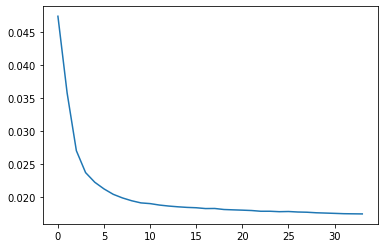

In [61]:
plt.plot(mlp_reg.loss_curve_)

In [26]:
def plot_results(X, y, lin_reg_model, name):
    plt.figure(figsize=(5,5))
    y_pred = lin_reg_model.predict(X)
    plt.scatter(y_pred,y, alpha=0.2)
    plt.plot([y_pred.min(),y_pred.max()],[y.min(),y.max()],'k')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("R2 Score = " +str(r2_score(lin_reg_model.predict(X), y)))
    plt.savefig(name+'.svg', format='svg')

In [62]:
X_test_scaled = scaler_pipeline.transform(X_test)

In [63]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_test = np.sqrt(mean_squared_error(mlp_reg.predict(X_test_scaled),y_test))
rmse_train = np.sqrt(mean_squared_error(mlp_reg.predict(X_train_scaled),y_train))
print("RMSE on train and test is ", rmse_train, rmse_test)

RMSE on train and test is  0.18719996252612367 0.19040708678270427


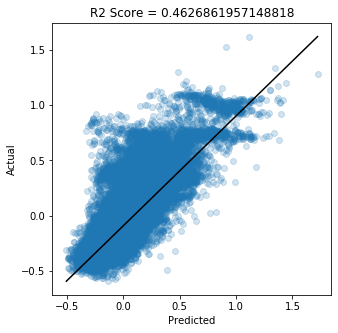

In [64]:
plot_results(X_train_scaled, y_train, mlp_reg, "Without_PCA_Train")

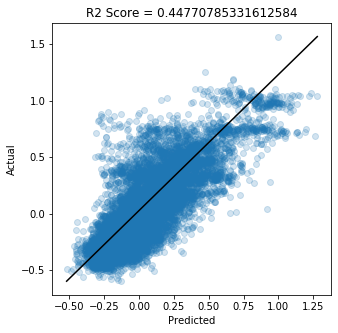

In [65]:
plot_results(X_test_scaled, y_test, mlp_reg, "Without_PCA_Test")